In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model

import imgaug as ia
import imgaug.augmenters as iaa

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES, FILE_DATASET
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)
FILE_BEST_MODEL = join(PATH_TO_ROOT, 'models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5')

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_AUTOENCODER_SAMPLES)
print(FILE_BEST_MODEL)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces_eyes/dataset_dlib.pkl
../../data/unsupervised_supervised_samples.pkl
../../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=(160, 160))
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = np.array(dataset.images)
mrks = np.array(dataset.mrks)
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(5574, 160, 160, 3) float32
(5574, 23) int32
(5574, 4) float64
5574


In [7]:
y_eyes.min(), y_eyes.max()

(51.5, 108.0)

#### divide train and test

In [8]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train_reqs, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

y_train_eyes = y_eyes[x_train_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(5009, 160, 160, 3) (5009, 23) (5009, 4)
(565, 160, 160, 3) (565, 23) (565, 4)


In [9]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# Data Augmentation 

In [10]:
class ImageLandmarkGenerator(Sequence):
    """ImageDataGenerator + ImgAug"""
    def __init__(self, x, y_reqs, y_eyes, batch_size=32, shuffle=True, **affine_kwargs):
        self.x = x
        self.y_reqs = y_reqs
        self.y_eyes = y_eyes
        self.batch_size = min(batch_size, x.shape[0])
        self.shuffle = shuffle
        self.aug = iaa.Affine(**affine_kwargs)
        self.indexes = np.arange(self.x.shape[0])
        if shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return self.x.shape[0] // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = self.x[indexes]
        reqs = self.y_reqs[indexes]
        landmarks = self.y_eyes[indexes]
        shape = self.x.shape[1:]
        
        keypoints = [ia.KeypointsOnImage.from_xy_array(landmark.reshape(-1, 2), shape=shape) for landmark in landmarks]
        images_aug, keypoints_aug = self.aug(images=images, keypoints=keypoints)
        landmarks_aug = np.array([kp.to_xy_array().flatten() for kp in keypoints_aug])

        return images_aug / 255, [images_aug / 255, reqs, landmarks_aug / x.shape[1]]

(3, 160, 160, 3) (3, 4)


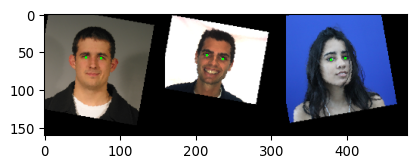

In [11]:
affine_params = dict(
    translate_percent=[-0.1, 0.1],
    rotate=[-10, 10],
    scale=[0.9, 1.1],
    order=0,
)

gen = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=3, **affine_params)
_, (images, _, landmarks) = gen.__getitem__(0)
print(images.shape, landmarks.shape)

draw_list = []
for im, landmark in zip(images, landmarks):
    kp = ia.KeypointsOnImage.from_xy_array((landmark * x_train.shape[1]).reshape(-1, 2), shape=im.shape)
    draw_list.append(kp.draw_on_image((im * 255).astype(np.uint8)[:, :, ::-1], size=3))

ia.imshow(np.hstack(draw_list))

# Model Training 

In [12]:
custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc
}

best_model = load_model(FILE_BEST_MODEL, custom_objects=custom_objects)

for layer in best_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


In [13]:
def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate, name=drop_name)(prev_input)
    out = Dense(units, activation=activation, name=dense_name)(prev_input)
    return out

In [14]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_EYES = y_train_eyes.shape[1]

avg_pool = best_model.get_layer("global_average_pooling2d_1").output

dense_3 = dense_layer(3, avg_pool, 64)
dense_4 = dense_layer(4, dense_3, 64)
regress = Dense(units=N_EYES, activation='sigmoid', name='output_eyes')(dense_4)

model = Model(
    inputs=best_model.inputs,
    outputs=[
        best_model.get_layer("decoded").output,
        best_model.get_layer("outputs").output,
        regress
    ],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

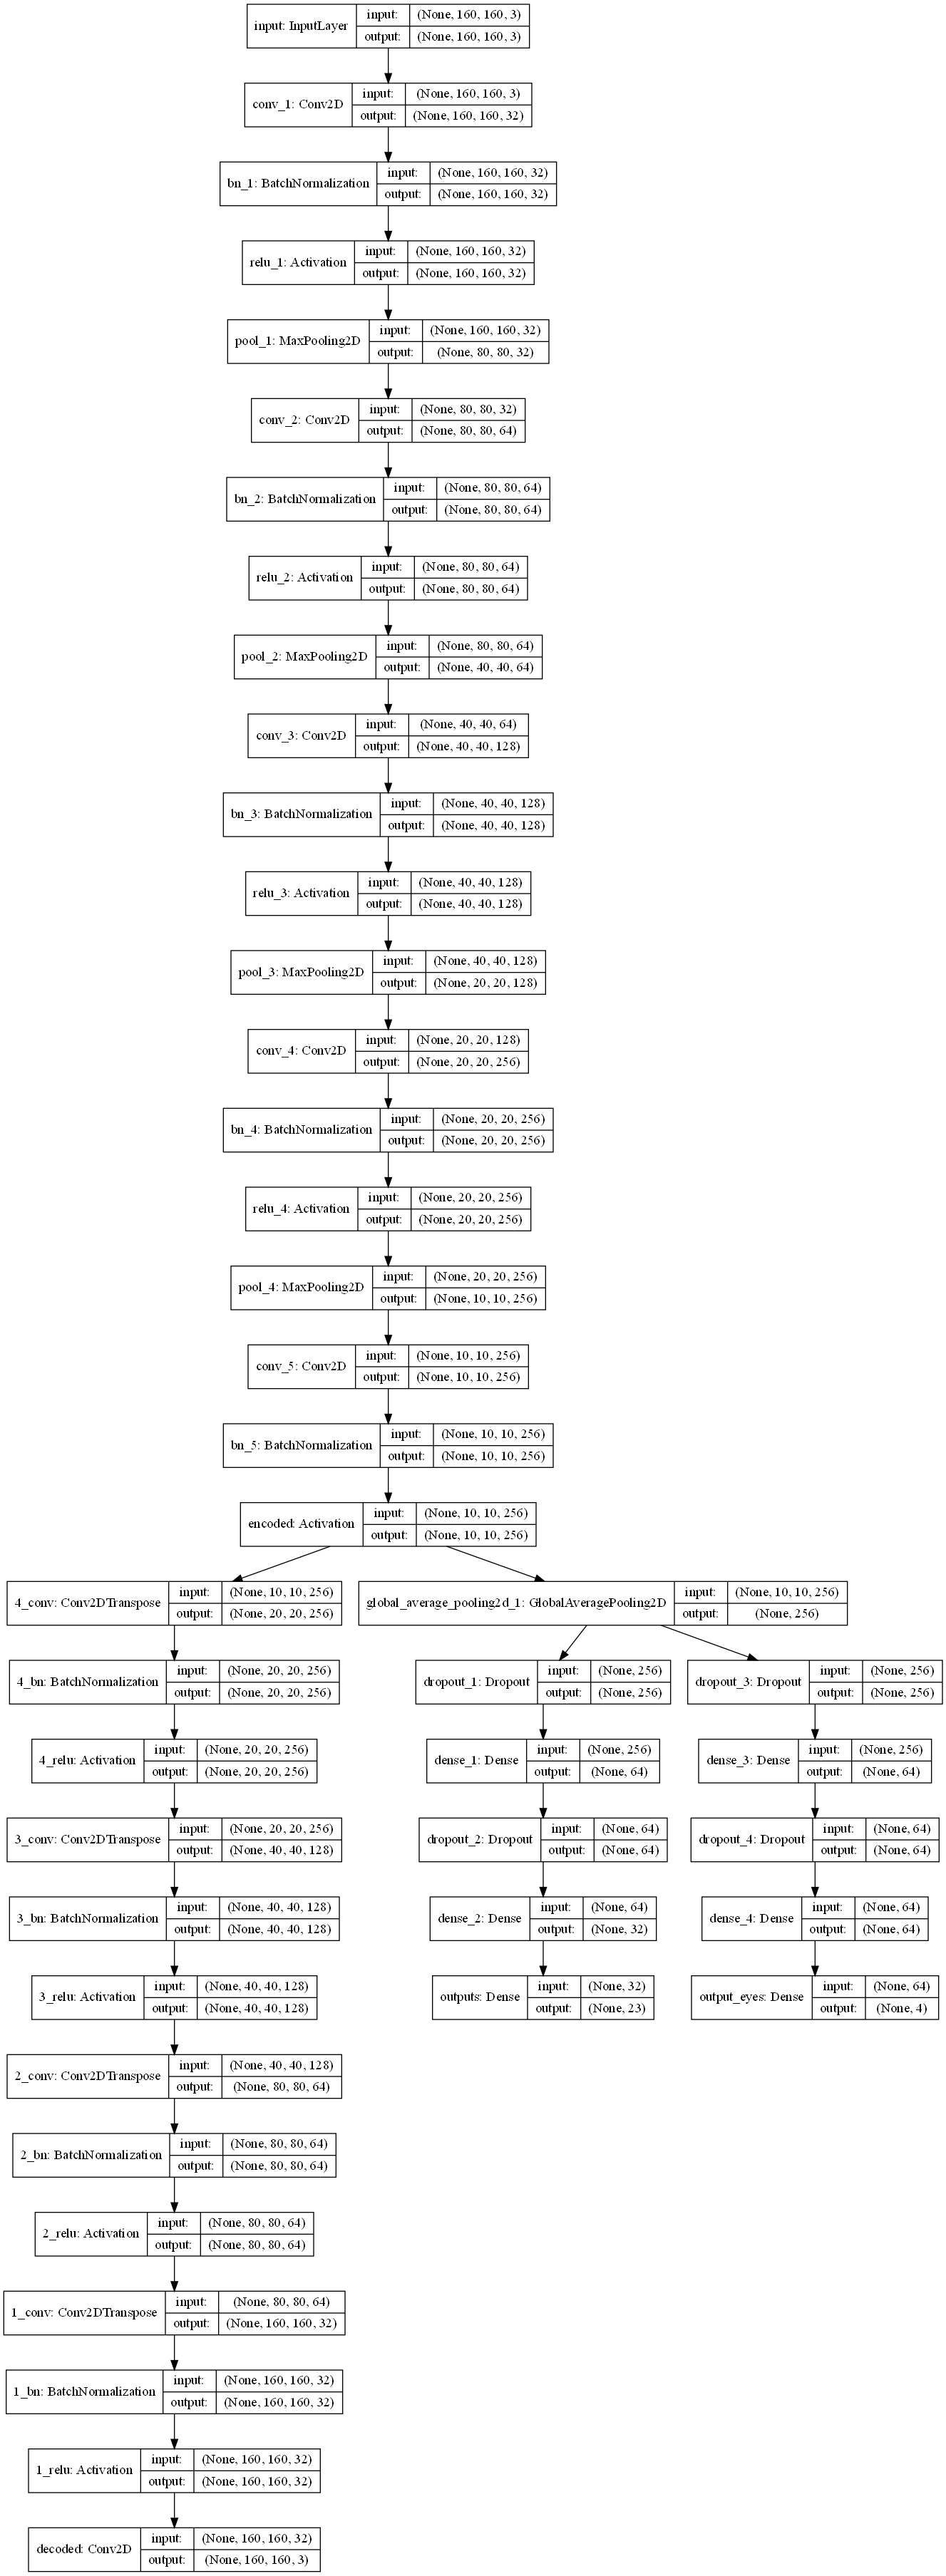

In [15]:
plot_model(model, show_shapes=True)

Epoch 1/500
100/100 [==============================] - 18s 183ms/step - loss: 0.0075 - decoded_loss: 0.0079 - outputs_loss: 0.2981 - output_eyes_loss: 0.0075 - outputs_accuracy: 0.8844 - outputs_precision: 0.9103 - outputs_recall: 0.9493 - outputs_f1: 0.9293 - outputs_fbeta: 0.9386 - outputs_specificity: 0.6232 - outputs_negative_predictive_value: 0.7517 - outputs_matthews_correlation_coefficient: 0.6153 - output_eyes_mae: 0.0723 - output_eyes_mse: 0.0075 - val_loss: 0.0023 - val_decoded_loss: 0.0082 - val_outputs_loss: 0.2660 - val_output_eyes_loss: 0.0025 - val_outputs_accuracy: 0.9064 - val_outputs_precision: 0.9378 - val_outputs_recall: 0.9447 - val_outputs_f1: 0.9412 - val_outputs_fbeta: 0.9408 - val_outputs_specificity: 0.7580 - val_outputs_negative_predictive_value: 0.7794 - val_outputs_matthews_correlation_coefficient: 0.7097 - val_output_eyes_mae: 0.0386 - val_output_eyes_mse: 0.0025

Epoch 00001: val_output_eyes_loss improved from inf to 0.00255, saving model to ../../models/


Epoch 00008: val_output_eyes_loss improved from 0.00104 to 0.00103, saving model to ../../models/unsupervised_supervised/multilearner_2022_07_11-22_13_15.h5
Epoch 9/500
100/100 [==============================] - 15s 145ms/step - loss: 0.0016 - decoded_loss: 0.0080 - outputs_loss: 0.2964 - output_eyes_loss: 0.0016 - outputs_accuracy: 0.8834 - outputs_precision: 0.9101 - outputs_recall: 0.9482 - outputs_f1: 0.9286 - outputs_fbeta: 0.9376 - outputs_specificity: 0.6239 - outputs_negative_predictive_value: 0.7490 - outputs_matthews_correlation_coefficient: 0.6137 - output_eyes_mae: 0.0289 - output_eyes_mse: 0.0016 - val_loss: 7.7749e-04 - val_decoded_loss: 0.0083 - val_outputs_loss: 0.2691 - val_output_eyes_loss: 9.2452e-04 - val_outputs_accuracy: 0.9023 - val_outputs_precision: 0.9394 - val_outputs_recall: 0.9372 - val_outputs_f1: 0.9382 - val_outputs_fbeta: 0.9347 - val_outputs_specificity: 0.7686 - val_outputs_negative_predictive_value: 0.7617 - val_outputs_matthews_correlation_coeffici


Epoch 00016: val_output_eyes_loss improved from 0.00056 to 0.00054, saving model to ../../models/unsupervised_supervised/multilearner_2022_07_11-22_13_15.h5
Epoch 17/500
100/100 [==============================] - 14s 144ms/step - loss: 0.0012 - decoded_loss: 0.0080 - outputs_loss: 0.3050 - output_eyes_loss: 0.0012 - outputs_accuracy: 0.8814 - outputs_precision: 0.9102 - outputs_recall: 0.9453 - outputs_f1: 0.9274 - outputs_fbeta: 0.9352 - outputs_specificity: 0.6239 - outputs_negative_predictive_value: 0.7377 - outputs_matthews_correlation_coefficient: 0.6070 - output_eyes_mae: 0.0228 - output_eyes_mse: 0.0012 - val_loss: 6.2614e-04 - val_decoded_loss: 0.0082 - val_outputs_loss: 0.2588 - val_output_eyes_loss: 5.4869e-04 - val_outputs_accuracy: 0.9051 - val_outputs_precision: 0.9367 - val_outputs_recall: 0.9438 - val_outputs_f1: 0.9402 - val_outputs_fbeta: 0.9398 - val_outputs_specificity: 0.7580 - val_outputs_negative_predictive_value: 0.7792 - val_outputs_matthews_correlation_coeffic


Epoch 00024: val_output_eyes_loss improved from 0.00050 to 0.00049, saving model to ../../models/unsupervised_supervised/multilearner_2022_07_11-22_13_15.h5
Epoch 25/500
100/100 [==============================] - 15s 146ms/step - loss: 0.0011 - decoded_loss: 0.0079 - outputs_loss: 0.2922 - output_eyes_loss: 0.0011 - outputs_accuracy: 0.8849 - outputs_precision: 0.9124 - outputs_recall: 0.9478 - outputs_f1: 0.9297 - outputs_fbeta: 0.9380 - outputs_specificity: 0.6290 - outputs_negative_predictive_value: 0.7458 - outputs_matthews_correlation_coefficient: 0.6158 - output_eyes_mae: 0.0213 - output_eyes_mse: 0.0011 - val_loss: 3.5827e-04 - val_decoded_loss: 0.0083 - val_outputs_loss: 0.2635 - val_output_eyes_loss: 5.3048e-04 - val_outputs_accuracy: 0.9057 - val_outputs_precision: 0.9375 - val_outputs_recall: 0.9443 - val_outputs_f1: 0.9408 - val_outputs_fbeta: 0.9402 - val_outputs_specificity: 0.7567 - val_outputs_negative_predictive_value: 0.7779 - val_outputs_matthews_correlation_coeffic

100/100 [==============================] - 14s 145ms/step - loss: 9.2684e-04 - decoded_loss: 0.0079 - outputs_loss: 0.2996 - output_eyes_loss: 9.2684e-04 - outputs_accuracy: 0.8847 - outputs_precision: 0.9118 - outputs_recall: 0.9482 - outputs_f1: 0.9295 - outputs_fbeta: 0.9382 - outputs_specificity: 0.6271 - outputs_negative_predictive_value: 0.7468 - outputs_matthews_correlation_coefficient: 0.6151 - output_eyes_mae: 0.0201 - output_eyes_mse: 9.2684e-04 - val_loss: 4.6246e-04 - val_decoded_loss: 0.0083 - val_outputs_loss: 0.2585 - val_output_eyes_loss: 5.1660e-04 - val_outputs_accuracy: 0.9058 - val_outputs_precision: 0.9380 - val_outputs_recall: 0.9433 - val_outputs_f1: 0.9406 - val_outputs_fbeta: 0.9395 - val_outputs_specificity: 0.7638 - val_outputs_negative_predictive_value: 0.7785 - val_outputs_matthews_correlation_coefficient: 0.7115 - val_output_eyes_mae: 0.0170 - val_output_eyes_mse: 5.1660e-04

Epoch 00033: val_output_eyes_loss did not improve from 0.00041
Epoch 34/500
100/1

100/100 [==============================] - 14s 144ms/step - loss: 9.7795e-04 - decoded_loss: 0.0080 - outputs_loss: 0.3044 - output_eyes_loss: 9.7795e-04 - outputs_accuracy: 0.8812 - outputs_precision: 0.9091 - outputs_recall: 0.9462 - outputs_f1: 0.9272 - outputs_fbeta: 0.9358 - outputs_specificity: 0.6200 - outputs_negative_predictive_value: 0.7407 - outputs_matthews_correlation_coefficient: 0.6063 - output_eyes_mae: 0.0201 - output_eyes_mse: 9.7795e-04 - val_loss: 6.5180e-04 - val_decoded_loss: 0.0083 - val_outputs_loss: 0.2756 - val_output_eyes_loss: 3.9549e-04 - val_outputs_accuracy: 0.9010 - val_outputs_precision: 0.9350 - val_outputs_recall: 0.9405 - val_outputs_f1: 0.9377 - val_outputs_fbeta: 0.9370 - val_outputs_specificity: 0.7474 - val_outputs_negative_predictive_value: 0.7669 - val_outputs_matthews_correlation_coefficient: 0.6947 - val_output_eyes_mae: 0.0149 - val_output_eyes_mse: 3.9549e-04

Epoch 00041: val_output_eyes_loss improved from 0.00041 to 0.00040, saving model 

100/100 [==============================] - 15s 151ms/step - loss: 8.7856e-04 - decoded_loss: 0.0080 - outputs_loss: 0.2978 - output_eyes_loss: 8.7856e-04 - outputs_accuracy: 0.8813 - outputs_precision: 0.9097 - outputs_recall: 0.9459 - outputs_f1: 0.9273 - outputs_fbeta: 0.9359 - outputs_specificity: 0.6208 - outputs_negative_predictive_value: 0.7381 - outputs_matthews_correlation_coefficient: 0.6056 - output_eyes_mae: 0.0192 - output_eyes_mse: 8.7856e-04 - val_loss: 2.8680e-04 - val_decoded_loss: 0.0084 - val_outputs_loss: 0.2747 - val_output_eyes_loss: 4.7097e-04 - val_outputs_accuracy: 0.9024 - val_outputs_precision: 0.9366 - val_outputs_recall: 0.9407 - val_outputs_f1: 0.9386 - val_outputs_fbeta: 0.9368 - val_outputs_specificity: 0.7568 - val_outputs_negative_predictive_value: 0.7675 - val_outputs_matthews_correlation_coefficient: 0.7005 - val_output_eyes_mae: 0.0156 - val_output_eyes_mse: 4.7097e-04

Epoch 00049: val_output_eyes_loss did not improve from 0.00040
Epoch 50/500
100/1

100/100 [==============================] - 14s 145ms/step - loss: 9.2947e-04 - decoded_loss: 0.0081 - outputs_loss: 0.2960 - output_eyes_loss: 9.2947e-04 - outputs_accuracy: 0.8850 - outputs_precision: 0.9120 - outputs_recall: 0.9486 - outputs_f1: 0.9299 - outputs_fbeta: 0.9386 - outputs_specificity: 0.6231 - outputs_negative_predictive_value: 0.7452 - outputs_matthews_correlation_coefficient: 0.6127 - output_eyes_mae: 0.0197 - output_eyes_mse: 9.2947e-04 - val_loss: 4.5283e-04 - val_decoded_loss: 0.0082 - val_outputs_loss: 0.2597 - val_output_eyes_loss: 4.9739e-04 - val_outputs_accuracy: 0.9040 - val_outputs_precision: 0.9364 - val_outputs_recall: 0.9429 - val_outputs_f1: 0.9396 - val_outputs_fbeta: 0.9387 - val_outputs_specificity: 0.7539 - val_outputs_negative_predictive_value: 0.7741 - val_outputs_matthews_correlation_coefficient: 0.7035 - val_output_eyes_mae: 0.0160 - val_output_eyes_mse: 4.9739e-04

Epoch 00057: val_output_eyes_loss did not improve from 0.00040
Epoch 58/500
100/1

100/100 [==============================] - 14s 144ms/step - loss: 8.9018e-04 - decoded_loss: 0.0080 - outputs_loss: 0.2962 - output_eyes_loss: 8.9018e-04 - outputs_accuracy: 0.8837 - outputs_precision: 0.9103 - outputs_recall: 0.9485 - outputs_f1: 0.9289 - outputs_fbeta: 0.9381 - outputs_specificity: 0.6208 - outputs_negative_predictive_value: 0.7466 - outputs_matthews_correlation_coefficient: 0.6113 - output_eyes_mae: 0.0192 - output_eyes_mse: 8.9018e-04 - val_loss: 5.7296e-04 - val_decoded_loss: 0.0082 - val_outputs_loss: 0.2620 - val_output_eyes_loss: 5.5553e-04 - val_outputs_accuracy: 0.9055 - val_outputs_precision: 0.9381 - val_outputs_recall: 0.9432 - val_outputs_f1: 0.9405 - val_outputs_fbeta: 0.9392 - val_outputs_specificity: 0.7578 - val_outputs_negative_predictive_value: 0.7774 - val_outputs_matthews_correlation_coefficient: 0.7079 - val_output_eyes_mae: 0.0163 - val_output_eyes_mse: 5.5553e-04

Epoch 00065: val_output_eyes_loss did not improve from 0.00040
Epoch 66/500
100/1

100/100 [==============================] - 14s 144ms/step - loss: 8.4055e-04 - decoded_loss: 0.0079 - outputs_loss: 0.2985 - output_eyes_loss: 8.4055e-04 - outputs_accuracy: 0.8830 - outputs_precision: 0.9104 - outputs_recall: 0.9472 - outputs_f1: 0.9284 - outputs_fbeta: 0.9369 - outputs_specificity: 0.6248 - outputs_negative_predictive_value: 0.7457 - outputs_matthews_correlation_coefficient: 0.6123 - output_eyes_mae: 0.0189 - output_eyes_mse: 8.4055e-04 - val_loss: 3.5769e-04 - val_decoded_loss: 0.0084 - val_outputs_loss: 0.2645 - val_output_eyes_loss: 4.4085e-04 - val_outputs_accuracy: 0.9033 - val_outputs_precision: 0.9371 - val_outputs_recall: 0.9417 - val_outputs_f1: 0.9393 - val_outputs_fbeta: 0.9383 - val_outputs_specificity: 0.7543 - val_outputs_negative_predictive_value: 0.7690 - val_outputs_matthews_correlation_coefficient: 0.7007 - val_output_eyes_mae: 0.0156 - val_output_eyes_mse: 4.4085e-04

Epoch 00073: val_output_eyes_loss did not improve from 0.00037
Epoch 74/500
100/1

100/100 [==============================] - 14s 144ms/step - loss: 8.2966e-04 - decoded_loss: 0.0080 - outputs_loss: 0.3018 - output_eyes_loss: 8.2966e-04 - outputs_accuracy: 0.8832 - outputs_precision: 0.9098 - outputs_recall: 0.9481 - outputs_f1: 0.9285 - outputs_fbeta: 0.9375 - outputs_specificity: 0.6249 - outputs_negative_predictive_value: 0.7498 - outputs_matthews_correlation_coefficient: 0.6145 - output_eyes_mae: 0.0186 - output_eyes_mse: 8.2966e-04 - val_loss: 4.4530e-04 - val_decoded_loss: 0.0083 - val_outputs_loss: 0.2685 - val_output_eyes_loss: 4.2516e-04 - val_outputs_accuracy: 0.9005 - val_outputs_precision: 0.9365 - val_outputs_recall: 0.9380 - val_outputs_f1: 0.9372 - val_outputs_fbeta: 0.9346 - val_outputs_specificity: 0.7576 - val_outputs_negative_predictive_value: 0.7610 - val_outputs_matthews_correlation_coefficient: 0.6963 - val_output_eyes_mae: 0.0156 - val_output_eyes_mse: 4.2516e-04

Epoch 00081: val_output_eyes_loss did not improve from 0.00037
Epoch 82/500
100/1

100/100 [==============================] - 14s 145ms/step - loss: 7.4163e-04 - decoded_loss: 0.0080 - outputs_loss: 0.3019 - output_eyes_loss: 7.4163e-04 - outputs_accuracy: 0.8822 - outputs_precision: 0.9097 - outputs_recall: 0.9470 - outputs_f1: 0.9279 - outputs_fbeta: 0.9366 - outputs_specificity: 0.6214 - outputs_negative_predictive_value: 0.7417 - outputs_matthews_correlation_coefficient: 0.6081 - output_eyes_mae: 0.0180 - output_eyes_mse: 7.4163e-04 - val_loss: 3.0325e-04 - val_decoded_loss: 0.0083 - val_outputs_loss: 0.2644 - val_output_eyes_loss: 4.6480e-04 - val_outputs_accuracy: 0.9068 - val_outputs_precision: 0.9408 - val_outputs_recall: 0.9418 - val_outputs_f1: 0.9413 - val_outputs_fbeta: 0.9390 - val_outputs_specificity: 0.7709 - val_outputs_negative_predictive_value: 0.7749 - val_outputs_matthews_correlation_coefficient: 0.7140 - val_output_eyes_mae: 0.0166 - val_output_eyes_mse: 4.6480e-04

Epoch 00089: val_output_eyes_loss did not improve from 0.00037
Epoch 90/500
100/1

100/100 [==============================] - 14s 144ms/step - loss: 8.1953e-04 - decoded_loss: 0.0080 - outputs_loss: 0.2933 - output_eyes_loss: 8.1953e-04 - outputs_accuracy: 0.8842 - outputs_precision: 0.9113 - outputs_recall: 0.9478 - outputs_f1: 0.9291 - outputs_fbeta: 0.9377 - outputs_specificity: 0.6281 - outputs_negative_predictive_value: 0.7480 - outputs_matthews_correlation_coefficient: 0.6159 - output_eyes_mae: 0.0182 - output_eyes_mse: 8.1953e-04 - val_loss: 3.4378e-04 - val_decoded_loss: 0.0083 - val_outputs_loss: 0.2655 - val_output_eyes_loss: 4.6938e-04 - val_outputs_accuracy: 0.9048 - val_outputs_precision: 0.9389 - val_outputs_recall: 0.9412 - val_outputs_f1: 0.9400 - val_outputs_fbeta: 0.9376 - val_outputs_specificity: 0.7672 - val_outputs_negative_predictive_value: 0.7735 - val_outputs_matthews_correlation_coefficient: 0.7102 - val_output_eyes_mae: 0.0155 - val_output_eyes_mse: 4.6938e-04

Epoch 00097: val_output_eyes_loss did not improve from 0.00037
Epoch 98/500
100/1

100/100 [==============================] - 14s 144ms/step - loss: 7.3797e-04 - decoded_loss: 0.0079 - outputs_loss: 0.2949 - output_eyes_loss: 7.3797e-04 - outputs_accuracy: 0.8845 - outputs_precision: 0.9112 - outputs_recall: 0.9485 - outputs_f1: 0.9294 - outputs_fbeta: 0.9381 - outputs_specificity: 0.6265 - outputs_negative_predictive_value: 0.7484 - outputs_matthews_correlation_coefficient: 0.6154 - output_eyes_mae: 0.0178 - output_eyes_mse: 7.3797e-04 - val_loss: 4.8630e-04 - val_decoded_loss: 0.0082 - val_outputs_loss: 0.2630 - val_output_eyes_loss: 4.8792e-04 - val_outputs_accuracy: 0.9047 - val_outputs_precision: 0.9361 - val_outputs_recall: 0.9445 - val_outputs_f1: 0.9402 - val_outputs_fbeta: 0.9398 - val_outputs_specificity: 0.7507 - val_outputs_negative_predictive_value: 0.7794 - val_outputs_matthews_correlation_coefficient: 0.7048 - val_output_eyes_mae: 0.0165 - val_output_eyes_mse: 4.8792e-04

Epoch 00105: val_output_eyes_loss did not improve from 0.00037
Epoch 106/500
100/

100/100 [==============================] - 14s 144ms/step - loss: 8.7684e-04 - decoded_loss: 0.0079 - outputs_loss: 0.2984 - output_eyes_loss: 8.7684e-04 - outputs_accuracy: 0.8836 - outputs_precision: 0.9110 - outputs_recall: 0.9476 - outputs_f1: 0.9288 - outputs_fbeta: 0.9374 - outputs_specificity: 0.6251 - outputs_negative_predictive_value: 0.7441 - outputs_matthews_correlation_coefficient: 0.6121 - output_eyes_mae: 0.0189 - output_eyes_mse: 8.7684e-04 - val_loss: 3.9535e-04 - val_decoded_loss: 0.0084 - val_outputs_loss: 0.2716 - val_output_eyes_loss: 5.6647e-04 - val_outputs_accuracy: 0.9033 - val_outputs_precision: 0.9382 - val_outputs_recall: 0.9403 - val_outputs_f1: 0.9391 - val_outputs_fbeta: 0.9373 - val_outputs_specificity: 0.7605 - val_outputs_negative_predictive_value: 0.7673 - val_outputs_matthews_correlation_coefficient: 0.7029 - val_output_eyes_mae: 0.0161 - val_output_eyes_mse: 5.6647e-04

Epoch 00113: val_output_eyes_loss did not improve from 0.00037
Epoch 114/500
100/

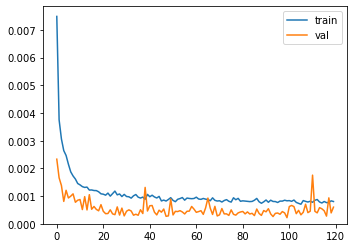

In [16]:
DECODED_LOSS_WEIGHT = 0.0
REQS_LOSS_WEIGHT = 0.0
EYES_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy",
    "output_eyes": "mean_squared_error"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["mae", "mse"]
}
METRIC_TO_MONITOR = "val_output_eyes_loss"

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="min", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="min", patience=50, verbose=1, restore_best_weights=True)
]

affine_params = dict(
    translate_percent=[-0.1, 0.1],
    rotate=[-10, 10],
    scale=[0.9, 1.1],
    order=0,
)

gen_train = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=32, **affine_params)
gen_valid = ImageLandmarkGenerator(x_val, y_val_reqs, y_val_eyes, batch_size=32, **affine_params)

hist = model.fit_generator(
    gen_train,
    steps_per_epoch=100,
    epochs=500,
    validation_data=gen_valid,
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

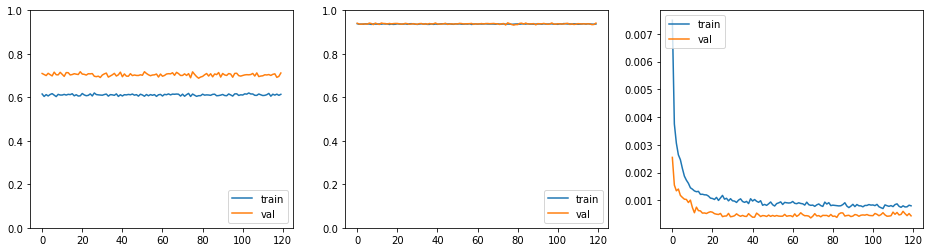

In [17]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history['output_eyes_loss'], label='train')
plt.plot(history['val_output_eyes_loss'], label='val')
plt.legend(loc='upper left')

# Test Model

[1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
[[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]]
[69.5 69.5 93.5 69. ]
[52.56608  60.947704 78.23494  59.586685]


Text(0.5, 1.0, 'decoded image')

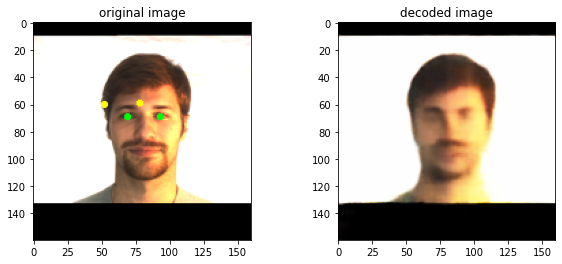

In [29]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true_reqs = y_val_reqs[random_idx]
y_true_eyes = y_val_eyes[random_idx]

y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im / 255)
y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)
y_pred_eyes = (y_pred_eyes * im.shape[1]).flatten()

print(y_true_reqs, y_pred_reqs, sep='\n')
print(y_true_eyes, y_pred_eyes, sep='\n')

im = im.squeeze()[:, :, ::-1].astype(np.uint8)
true_r = tuple(y_true_eyes[:2].astype(np.int))
true_l = tuple(y_true_eyes[2:].astype(np.int))
pred_r = tuple(y_pred_eyes[:2].astype(np.int))
pred_l = tuple(y_pred_eyes[2:].astype(np.int))
cv2.circle(im, true_r, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, true_l, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, pred_r, radius=1, color=(255, 255, 0), thickness=2)
cv2.circle(im, pred_l, radius=1, color=(255, 255, 0), thickness=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [ ]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('outputs').output, model.get_layer('output_eyes').output],
    name="ICAOnet"
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

In [ ]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)
y_pred_clf, y_pred_reg = model_clf.predict(im)
assert(np.allclose(y_pred_ori[1], y_pred_clf))
assert(np.allclose(y_pred_ori[2], y_pred_reg))

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
image_files = np.array(dataset.image_files)[x_val_idx]
data = dataset.images[x_val_idx]
mrks = dataset.mrks[x_val_idx]

image_files = [basename(filepath) for filepath in image_files]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [ ]:
mlflow.end_run()